# Testing data and Models
In this notebook the data is loaded, preprocessed. And the baseline model is built from scratch.

In [1]:
# Import packages
import pandas as pd

# graphics
import matplotlib.pyplot as plt
import seaborn as sns

# text procesing
import re
from datetime import datetime
import numpy as np

# for the model
import tensorflow as tf
from keras import layers, models

# split the dataset into train and test parts
from sklearn.model_selection import train_test_split

In [2]:
# Movies: 
raw_movies = pd.read_csv('../data/raw/ml-latest-small/movies.csv', encoding='utf-8')
# Users' ratings
raw_ratings = pd.read_csv('../data/raw/ml-latest-small/ratings.csv', encoding='utf-8')
# Tags: Xxx, abc
tags_raw = pd.read_csv('../data/raw/ml-latest-small/tags.csv', encoding='utf-8')

## Exploring the Data
Here I plan several hipotesis that represent new features:
+ Encode each genre and assigna weight to it. Maybe some genres have higher ratings overall

+ Assign a weight to each movie based on the number of views it has. Maybe the most viewed movies have a higher chance to receive a higher rating from a new user.

+ Maybe the ratings given by the users should be weighetd based on the number of movies watched by the user. 

In [3]:
# Function that process the raw data:
def raw_to_processed(raw_movies, raw_ratings):
    pro_movies = raw_movies.copy()

    # Extract the Year from the Title of the Movie (if its between parenthesis)
    pro_movies['Year'] = pro_movies['title'].apply(
        lambda x: int(x.split("(")[-1][:4].replace(")", "").strip()) # if there are 2 years (like 2006-2010), the first year is taken
            if "(" in x else np.nan)    # if theres a ( in the Name, set the year, else, a NA
            
    pro_movies['title'] = pro_movies['title'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())

    # copy raw ratings data:
    pro_ratings = raw_ratings.copy()

    # Add date column
    pro_ratings['Date'] = pro_ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
    
    # One-hot encoding of genres: 
    # First get a list of lists (each list is the list of genres for each movie)
    aux = [i.split('|') for i in pro_movies.genres.unique()]
    # Then create a set (unique array of elements) and remove the no genres listed
    vocab = list(set(i for k in aux for i in k))
    vocab.remove('(no genres listed)')
    print("Genres present in the dataset: ", vocab)

    # Now, create a column for each genre:
    for genre in vocab:
        pro_movies[genre] = pro_movies.genres.apply(lambda x: 1 if genre in x else 0)

    # One-hot encoding of genres: 
    # First get a list of lists (each list is the list of genres for each movie)
    aux = [i.split('|') for i in pro_movies.genres.unique()]
    # Then create a set (unique array of elements) and remove the no genres listed
    vocab = list(set(i for k in aux for i in k))
    vocab.remove('(no genres listed)')
    print("Genres present in the dataset: ", vocab)

    # Now, create a column for each genre:
    for genre in vocab:
        pro_movies[genre] = pro_movies.genres.apply(lambda x: 1 if genre in x else 0)
    
    pro_ratings.to_csv("../data/processed/pro_ratings.csv", encoding='utf-8')
    pro_movies.to_csv("../data/processed/pro_movies.csv", encoding='utf-8')

    return pro_ratings, pro_movies, vocab

pro_ratings, pro_movies, vocab = raw_to_processed(raw_movies, raw_ratings)

Genres present in the dataset:  ['Sci-Fi', 'Children', 'Musical', 'Film-Noir', 'Horror', 'Thriller', 'Fantasy', 'Romance', 'Crime', 'Drama', 'Comedy', 'IMAX', 'Action', 'Mystery', 'Western', 'Adventure', 'Documentary', 'War', 'Animation']
Genres present in the dataset:  ['Sci-Fi', 'Children', 'Musical', 'Film-Noir', 'Horror', 'Thriller', 'Fantasy', 'Romance', 'Crime', 'Drama', 'Comedy', 'IMAX', 'Action', 'Mystery', 'Western', 'Adventure', 'Documentary', 'War', 'Animation']


Onehot encoding, in this case, is quite bad, as the dataframe shows below, it is very sparse. This means that our model will have a lot of entries that will, most of the time, receive 0 as input.

<AxesSubplot:>

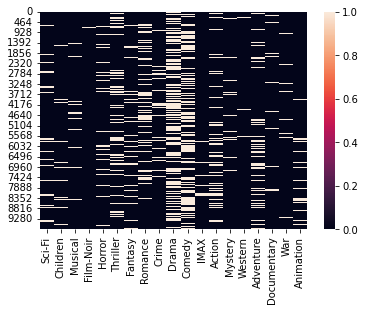

In [4]:
pro_movies
sns.heatmap(pro_movies[[i for i in vocab]])

## Feature Engineering
There are several approach to take in Movie recommendations.
+ Content based: recommend similar movies to the ones the user liked 
+ Collaborative filtering: if two users have similar ratings on some movies, one movie that one user already watched and rated it high is a good recommendation to the other user, if they didn't watched it already

This two models are merged with the context of each movie (The year and the genres, in this case).

In [5]:
# Create train and test Dataframes:
ready = pro_ratings

train_df, test_df = train_test_split(ready, test_size=0.3)

## Model definition:

In [10]:
# get the number of users and movies
#users_n, movies_n = len(pro_ratings.userId.unique()), len(pro_movies.movieId.unique())
users_n = pro_ratings.userId.max()
movies_n = pro_ratings.movieId.max()

print(users_n, movies_n)
# define the output dimmension of the embedding layer:
e_size = 5

# define the units of the hidden layers:
unidades = 20


# Now define the Input layers:
# Users:
users_input = layers.Input(name = "users_input", shape = (1,))
users_embedd = layers.Embedding(users_n + 1, e_size, name = "Users_Embeddings")(users_input)
# is this necesssary ? 
users_final = layers.Reshape(name = "users", target_shape=(e_size , ))(users_embedd)

# Movies:
movies_input = layers.Input(name = "movies_input", shape = (1,))
movies_embedd = layers.Embedding(movies_n + 1, e_size, name = "Movies_Embeddings")(movies_input)
# is this necesssary ? 
movies_final = layers.Reshape(name = "movies", target_shape=(e_size, ))(movies_embedd)
 
# Dot product between users and movies 
product = layers.Dot(name = 'Product', axes = 1, normalize = True)([users_final, movies_final]) 

# 2 hidden layers:
h1 = layers.Dense(name = 'H1', activation='relu', units = unidades)(product)
h2 = layers.Dense(name = 'H2', activation='relu', units = unidades)(h1)

# Output (Rating)
salida = layers.Concatenate()([h2, product])
# rating = layers.Dense(name = 'Rating', units = 1)(product)
rating = layers.Dense(name = 'Rating', units = 1)(salida)

# __ Model Declaration ____
model_basel = models.Model(inputs = [users_input, movies_input], outputs = rating, name = 'model_1')

# Model compiling
model_basel.compile(optimizer = 'adam', loss = 'mae', metrics = ['mean_absolute_percentage_error'])

610 193609


Visualize the model: 

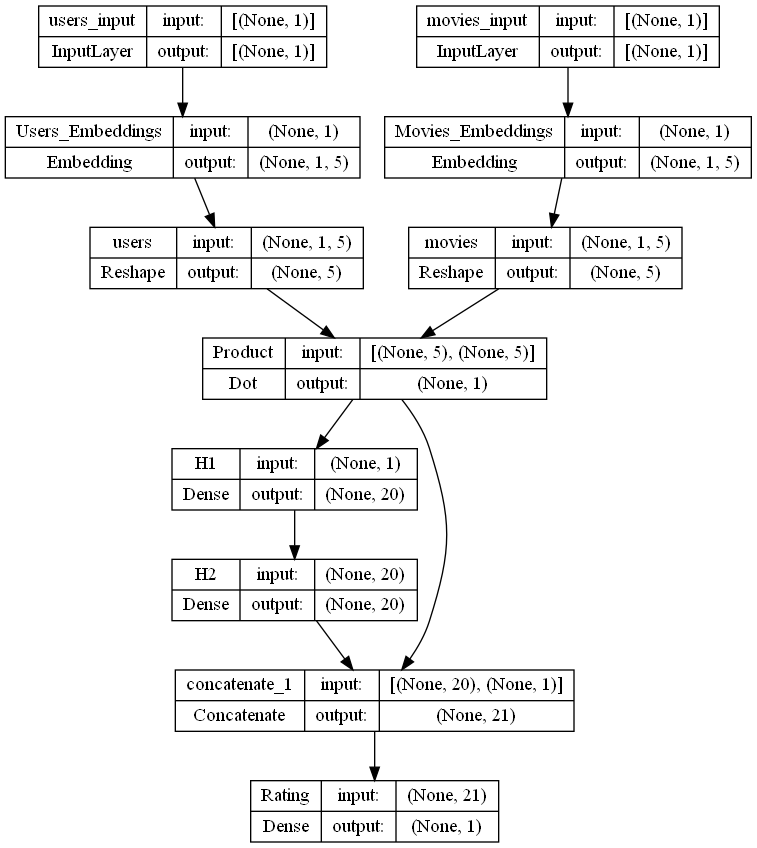

In [11]:
tf.keras.utils.plot_model(model_basel, show_shapes=True)

In [12]:
# Training:
EPOCHS = 15
BATCH_SIZE = 128


hist = model_basel.fit(x=[train_df['userId'], train_df['movieId']], y = train_df['rating'], 
         validation_split = 0.3, epochs=EPOCHS, batch_size= BATCH_SIZE, shuffle = False, verbose = True)

Epoch 1/15
387/387 [==============================] - 6s 13ms/step - loss: 1.4953 - mean_absolute_percentage_error: 51.9471 - val_loss: 0.8276 - val_mean_absolute_percentage_error: 38.5113
Epoch 2/15
387/387 [==============================] - 6s 14ms/step - loss: 0.8003 - mean_absolute_percentage_error: 37.9092 - val_loss: 0.8246 - val_mean_absolute_percentage_error: 39.0410
Epoch 3/15
387/387 [==============================] - 6s 15ms/step - loss: 0.7649 - mean_absolute_percentage_error: 36.6694 - val_loss: 0.8268 - val_mean_absolute_percentage_error: 38.8154
Epoch 4/15
204/387 [==============>...............] - ETA: 2s - loss: 0.7466 - mean_absolute_percentage_error: 35.0296

In [ ]:
predictions = model_basel.predict([test_df['userId'], test_df['movieId']])

In [ ]:
y_ = predictions
y = test_df['rating']
y = y.to_list()
err_basel = []

it = 0
print(len(y_), len(y))
for e in y_:
    err_basel.append(abs(e[0] - y[it]))
    it = it + 1

# Model 
Having a baseline model, the design of the final model starts here.

The baselien model only takes into account Colaborative Filtering:
+ The simmilarities between users: If several ratings from user "X" are the same or similar to the ones of user "Y" movies unwatched by "Y" but liked by "X" could be also liked by "Y"

In contrast, the final model will take into consideration the "Context" of each movie. Like the genres and the date.

In [ ]:
# function that returns a tf dataset ready to be fed to the model
def processed_to_final(pro_ratings, pro_movies, TEST_SIZE):
    df_final_beta = pro_ratings.copy()

    df_final_beta = df_final_beta.join(pro_movies.set_index('movieId'), on='movieId')
    df_final_beta.drop('genres', axis=1)

    train_df, test_df = train_test_split(df_final_beta, test_size=TEST_SIZE)
    train_df.to_csv("../data/final/train.csv")
    test_df.to_csv("../data/final/test.csv")

    return train_df, test_df


train_df, test_df = processed_to_final(pro_ratings, pro_movies, TEST_SIZE=0.3)

In [ ]:
# get the number of users and movies
#users_n, movies_n = len(pro_ratings.userId.unique()), len(pro_movies.movieId.unique())
users_n = pro_ratings.userId.max()
movies_n = pro_ratings.movieId.max()

# get the number of the lookup for genres embedding layer
genres_esize = len(vocab) + 1

print(users_n, movies_n)
# define the output dimmension of the embedding layer:
e_size = 50

# define the units of the hidden layers:
unidades = 20


# Now define the Input layers:
# Users:
users_input = layers.Input(name = "users_input", shape = (1,))
users_embedd = layers.Embedding(users_n + 1, e_size, name = "Users_Embeddings")(users_input)
# is this necesssary ? 
users_final = layers.Reshape(name = "users", target_shape=(e_size , ))(users_embedd)

# Movies:
movies_input = layers.Input(name = "movies_input", shape = (1,))
movies_embedd = layers.Embedding(movies_n + 1, e_size, name = "Movies_Embeddings")(movies_input)
# is this necesssary ? 
movies_final = layers.Reshape(name = "movies", target_shape=(e_size, ))(movies_embedd)
 
# Dot product between users and movies 
product = layers.Dot(name = 'Product', axes = 1, normalize = True)([users_final, movies_final]) 

# More inputs:
# Features (Genres)
genres_input = layers.Input(name = 'genres', shape = (19,))

# Merge both genres and dot product
union = layers.Concatenate()([genres_input, product])

# 2 hidden layers:
h1 = layers.Dense(name = 'H1', activation='relu', units = unidades)(union)
h2 = layers.Dense(name = 'H2', activation='relu', units = unidades)(h1)


# Dates: (better a normalized timestamp?)
# date = layers.Input(name = 'timestamp')

# Output (Rating)
rating = layers.Dense(name = 'Rating', units = 1)(h2)

# __ Model Declaration ____
model_final = models.Model(inputs = [users_input, movies_input, genres_input], outputs = rating, name = 'model_1')

# Model compiling
model_final.compile(optimizer = 'adam', loss = 'mae', metrics = ['mean_absolute_percentage_error'])

# Plot the model
tf.keras.utils.plot_model(model_final)

In [ ]:
# Train the model
EPOCHS = 5
BATCH_SIZE = 128

train_df['rating']

hist_final = model_final.fit(x=[train_df['userId'], train_df['movieId'], train_df[vocab]], y = train_df['rating'], 
         validation_split = 0.3, epochs=EPOCHS, batch_size= BATCH_SIZE, shuffle = False, verbose = True)

In [ ]:
# Test the model
predictions = model_final.predict([test_df['userId'], test_df['movieId'], test_df[vocab]])
y_ = predictions
y = test_df['rating']

print("prediccions: ", predictions)
print("rratings: ", test_df['rating'])

In [ ]:
it = 0
err_end = []
y = y.to_list()
for pred in y_:
    err_end.append(abs(pred[0] - y[it]))
    it = it + 1

In [ ]:
# Comparing results:
print("MAE of baseline model (15 epochs): ", np.mean(err_basel))
print("MAE of final model (5 epochs): ", np.mean(err_end))

## Future proposals:
+ Encode each genre and assign a weight to it. 
   Then predict the rating based on the weights of the genres. Maybe movies with some specific genres are more likely to receive a higher rating for the **average** user

+ Assign a weight to each movie that represents how many users viewed it. 
  Maybe the most viewed movies have a better chance to be a great recommendation
  to new users.

+ The more movies a user watches the more valuable their ratings, maybe.

+ Take into consideration Timestamp, maybe more recent movies are a better recommendation instead of older movies (with the same rating, like, Who watches Infinity War nowadays?)

+ Also, take into account the seasons (like halloween, christmas, and so on)